# WiFi Indoor Geolocation - Training depuis MQTT
## UVSQ SEE - Chargement Direct depuis Broker MQTT

**NOUVEAU :** Ce notebook se connecte directement au broker MQTT pour récupérer les données.

**Avantages :**
- Pas besoin de télécharger/uploader des CSV
- Données en temps réel depuis les Tab5
- Workflow simplifié
- Parfait pour collecte multi-groupes

**Configuration requise :**
- Broker MQTT accessible (HiveMQ Cloud ou public)
- Topics avec données de locations

**Output :**
- `nn_weights.json` (à déployer sur Tab5)

## Step 1: Install Libraries

In [ ]:
# Install required libraries
!pip install numpy pandas scikit-learn tensorflow matplotlib paho-mqtt -q

print("✓ Libraries installed")

✓ Libraries installed


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import paho.mqtt.client as mqtt
import time
from collections import defaultdict

## Step 2: Configuration MQTT

**Modifier selon votre broker :**

In [ ]:
# ========== CONFIGURATION MQTT ==========

# Option 1: HiveMQ Cloud (TLS)
MQTT_BROKER = "bebdb8261f5e43f0a3a2f1560510608d.s1.eu.hivemq.cloud"
MQTT_PORT = 8883
MQTT_USE_TLS = True
MQTT_USERNAME = "m5TAB5"
MQTT_PASSWORD = "TAB5si92i*"

# Topics à écouter
TOPIC_PREFIX = "LaVilette"  # Écoute tous les topics LaVilette/#

# Durée d'écoute (secondes)
LISTEN_DURATION = 30  # 30 secondes pour recevoir les messages

print("Configuration MQTT:")
print(f"  Broker: {MQTT_BROKER}:{MQTT_PORT}")
print(f"  TLS: {MQTT_USE_TLS}")
print(f"  Topics: {TOPIC_PREFIX}/#")
print(f"  Listen duration: {LISTEN_DURATION}s")

Configuration MQTT:
  Broker: bebdb8261f5e43f0a3a2f1560510608d.s1.eu.hivemq.cloud:8883
  TLS: True
  Topics: LaVilette/#
  Listen duration: 30s


## Step 3: Connexion MQTT et Collecte des Données

**IMPORTANT :** Les Tab5 doivent avoir uploadé leurs données AVANT de lancer cette cellule.

In [ ]:
import json
import time
import paho.mqtt.client as mqtt
from collections import defaultdict

# --- CONFIGURATION À VÉRIFIER ---
TOPIC_DATA = "LaVilette/science/wifi/data"  # <--- LA LIGNE MANQUANTE
LISTEN_DURATION = 100

received_data = defaultdict(list)
message_count = 0
listening = False

def on_message(client, userdata, msg):
    global message_count, listening
    if not listening: return

    try:
        payload = json.loads(msg.payload.decode())
        location = payload.get('location', 'unknown')
        samples = payload.get('samples', [])

        for sample in samples:
            aps_list = sample.get('aps', [])
            rssi_values = [ap.get('rssi', -100.0) for ap in aps_list]
            if rssi_values:
                received_data[location].append(rssi_values)

        message_count += 1
        total_samples = sum(len(s) for s in received_data.values())
        print(f"✓ [{message_count}] Reçu de '{location}': +{len(samples)} points (Total: {total_samples})")

    except Exception as e:
        print(f"✗ Erreur: {e}")

# --- Connexion ---
client = mqtt.Client() # Tu peux ignorer le DeprecationWarning pour l'instant
client.on_message = on_message

# Si tu utilises HiveMQ Cloud (TLS obligatoire)
client.tls_set()
client.username_pw_set("m5TAB5", "TAB5si92i*")

print(f"Connexion au broker...")
client.connect("bebdb8261f5e43f0a3a2f1560510608d.s1.eu.hivemq.cloud", 8883, 60)
client.subscribe(TOPIC_DATA)
client.loop_start()

print("STATUT : CONNECTÉ ET PRÊT")

response = input("\nAppuyez sur 'y' pour lancer l'écoute : ").lower()
if response == 'y':
    listening = True
    print(f"🎧 Écoute active...")
    for i in range(LISTEN_DURATION):
        time.sleep(1)
    listening = False
    print(f"\n⌛ Terminé. Total : {sum(len(s) for s in received_data.values())} échantillons.")

client.loop_stop()
client.disconnect()

/tmp/ipython-input-3149774743.py:37: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client() # Tu peux ignorer le DeprecationWarning pour l'instant


Connexion au broker...
STATUT : CONNECTÉ ET PRÊT

Appuyez sur 'y' pour lancer l'écoute : Y
🎧 Écoute active...
✓ [1] Reçu de 'Zone 1': +10 points (Total: 10)
✓ [2] Reçu de 'Zone 1': +10 points (Total: 10)
✓ [3] Reçu de 'Zone 1': +10 points (Total: 20)✓ [4] Reçu de 'Zone 1': +10 points (Total: 20)

✓ [5] Reçu de 'Zone 1': +10 points (Total: 30)
✓ [6] Reçu de 'Zone 1': +10 points (Total: 30)
✓ [7] Reçu de 'Zone 1': +10 points (Total: 30)
✓ [8] Reçu de 'Zone 1': +10 points (Total: 40)
✓ [9] Reçu de 'Zone 1': +10 points (Total: 50)
✓ [10] Reçu de 'Zone 1': +10 points (Total: 50)
✓ [11] Reçu de 'Zone 2': +10 points (Total: 50)
✓ [12] Reçu de 'Zone 2': +10 points (Total: 60)
✓ [13] Reçu de 'Zone 2': +10 points (Total: 70)
✓ [14] Reçu de 'Zone 2': +10 points (Total: 70)
✓ [15] Reçu de 'Zone 2': +10 points (Total: 70)
✓ [16] Reçu de 'Zone 2': +10 points (Total: 80)
✓ [17] Reçu de 'Zone 2': +10 points (Total: 90)✓ [18] Reçu de 'Zone 2': +10 points (Total: 90)

✓ [19] Reçu de 'Zone 2': +10 points

<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

## Step 4: Convert MQTT Data to DataFrame

In [ ]:
import pandas as pd

# 1. Vérifications de sécurité
if not received_data:
    raise ValueError("❌ Aucune donnée reçue ! Relancez l'écoute et l'envoi sur le M5.")

# 2. Construction automatique du mapping à partir des données reçues
# On récupère les clés du premier échantillon reçu pour définir les colonnes
all_samples = []
all_labels = []
mac_headers = []

# Extraction dynamique des MACs
first_zone = list(received_data.keys())[0]
if received_data[first_zone]:
    # On récupère les MACs depuis le premier message pour la légende
    # Note: Dans le Step 3, on a déjà converti les objets en listes de RSSI
    num_columns = len(received_data[first_zone][0])
    mac_headers = [f"AP_{i}" for i in range(num_columns)]

# 3. Remplissage des listes pour Pandas
for location, samples in received_data.items():
    for sample in samples:
        all_samples.append(sample)
        all_labels.append(location)

# 4. Création du DataFrame Pandas
data = pd.DataFrame(all_samples, columns=mac_headers)
data['target'] = all_labels  # 'target' est le nom standard pour l'IA (la zone à prédire)

# 5. Affichage du résumé
print("=" * 60)
print("📊 DATASET GÉNÉRÉ AVEC SUCCÈS")
print("=" * 60)
print(f"✅ Total échantillons : {len(data)}")
print(f"📍 Zones détectées    : {list(data['target'].unique())}")
print(f"📡 Nombre de bornes  : {len(mac_headers)}")
print("\n📈 Répartition par zone :")
print(data['target'].value_counts())
print("=" * 60)

# Affichage des premières lignes
data.head()

📊 DATASET GÉNÉRÉ AVEC SUCCÈS
✅ Total échantillons : 350
📍 Zones détectées    : ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7']
📡 Nombre de bornes  : 10

📈 Répartition par zone :
target
Zone 1    50
Zone 2    50
Zone 3    50
Zone 4    50
Zone 5    50
Zone 6    50
Zone 7    50
Name: count, dtype: int64


,AP_0,AP_1,AP_2,AP_3,AP_4,AP_5,AP_6,AP_7,AP_8,AP_9,target
0,-40,-38,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
1,-50,-46,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
2,-40,-44,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
3,-42,-43,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
4,-41,-40,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1


In [ ]:
# Display first few rows
print("\nDataset preview:")
data.head(10)


Dataset preview:


,AP_0,AP_1,AP_2,AP_3,AP_4,AP_5,AP_6,AP_7,AP_8,AP_9,target
0,-40,-38,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
1,-50,-46,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
2,-40,-44,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
3,-42,-43,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
4,-41,-40,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
5,-44,-43,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
6,-45,-38,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
7,-37,-45,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
8,-36,-40,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1
9,-36,-43,-100,-100,-100,-100,-100,-100,-100,-100,Zone 1


## Step 5: Prepare Data for Training

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Extraction des caractéristiques (X) et des étiquettes (y)
# On récupère toutes les colonnes SAUF la dernière (qui est 'target')
X = data.drop(columns=['target']).values
y = data['target'].values

print(f"✅ Dimensions de X (Signaux) : {X.shape}")
print(f"✅ Dimensions de y (Zones)   : {y.shape}")

# 2. Encodage des noms de zones en nombres entiers (0, 1, 2...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n🔢 Correspondance de l'encodage :")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {i} : {label}")

num_classes = len(label_encoder.classes_)
print(f"\n✅ Nombre de classes détectées : {num_classes}")

# Petite vérification visuelle
print("\n👀 Aperçu des premières données encodées :")
for i in range(min(3, len(X))):
    print(f"   Signal: {X[i]} ---> Classe: {y_encoded[i]} ({y[i]})")

✅ Dimensions de X (Signaux) : (350, 10)
✅ Dimensions de y (Zones)   : (350,)

🔢 Correspondance de l'encodage :
   0 : Zone 1
   1 : Zone 2
   2 : Zone 3
   3 : Zone 4
   4 : Zone 5
   5 : Zone 6
   6 : Zone 7

✅ Nombre de classes détectées : 7

👀 Aperçu des premières données encodées :
   Signal: [ -40  -38 -100 -100 -100 -100 -100 -100 -100 -100] ---> Classe: 0 (Zone 1)
   Signal: [ -50  -46 -100 -100 -100 -100 -100 -100 -100 -100] ---> Classe: 0 (Zone 1)
   Signal: [ -40  -44 -100 -100 -100 -100 -100 -100 -100 -100] ---> Classe: 0 (Zone 1)


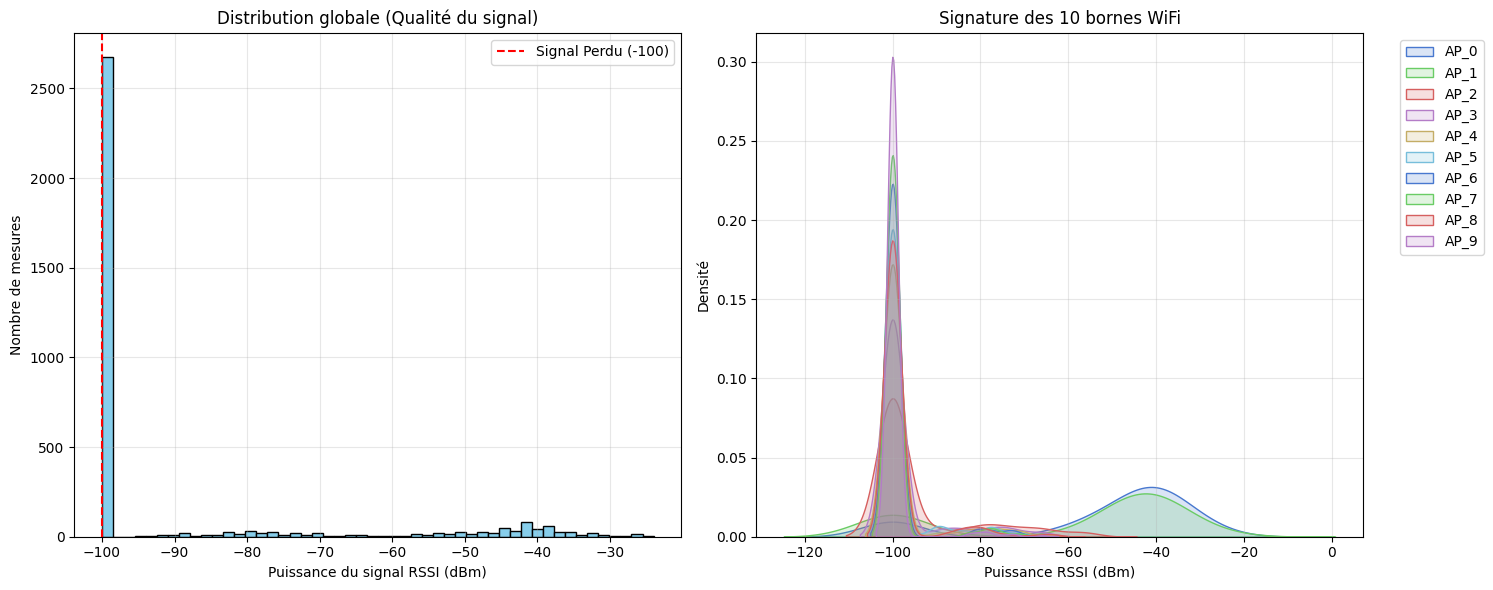

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- LIGNE CORRECTRICE ---
num_aps = X.shape[1]  # On récupère le nombre de bornes (colonnes) dynamiquement
# -------------------------

# Configuration du style
plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize=(15, 6))

# --- Graphique 1 : Distribution globale ---
plt.subplot(1, 2, 1)
# On aplatit toutes les valeurs pour voir la répartition générale
plt.hist(X.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(-100, color='red', linestyle='--', label='Signal Perdu (-100)')
plt.xlabel('Puissance du signal RSSI (dBm)')
plt.ylabel('Nombre de mesures')
plt.title('Distribution globale (Qualité du signal)')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Graphique 2 : Comparaison des bornes (APs) ---
plt.subplot(1, 2, 2)
# On utilise num_aps que nous venons de définir
for i in range(num_aps):
    # On ne trace que si la borne a des variations (évite les erreurs si une borne est toujours à -100)
    if X[:, i].std() > 0:
        sns.kdeplot(X[:, i], label=f'AP_{i}', fill=True, alpha=0.2)

plt.xlabel('Puissance RSSI (dBm)')
plt.ylabel('Densité')
plt.title('Signature des 10 bornes WiFi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Split Data & Normalize

In [ ]:
# ========== STEP 6 : PRÉPARATION ET NORMALISATION (CORRIGÉ) ==========

# 1. Split data : On passe à 0.25 (soit 25%) pour avoir 7 échantillons de test
# Cela permet d'avoir exactement 1 échantillon par zone (7 zones x 1 = 7)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples (1 par zone)")

# 2. Calculate normalization parameters (from training data ONLY)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Sécurité : Si une borne n'a jamais bougé, std sera 0.
# On remplace par 1 pour éviter la division par zéro (NaN).
std[std == 0] = 1.0

print(f"\nNormalization parameters:")
print(f"Mean: {mean}")
print(f"Std: {std}")

# 3. Normalize data
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

print(f"\nNormalized training data range: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Training set: 262 samples
Test set: 88 samples (1 par zone)

Normalization parameters:
Mean: [-52.15267176 -59.8129771  -94.56870229 -97.1259542  -98.05725191
 -98.27862595 -98.71374046 -98.8740458  -98.29007634 -99.48091603]
Std: [22.73695357 26.81786432 11.11876609  7.74913034  6.31130732  5.43197359
  5.29565951  5.01099688  5.98597413  3.51843812]

Normalized training data range: [-2.10, 9.52]


## Step 7: Build Neural Network

In [ ]:
# Build model
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(num_aps,), name='hidden'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295 (1.15 KB)

 Trainable params: 295 (1.15 KB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Train the Model

In [ ]:
# Train model
history = model.fit(
    X_train_norm, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1576 - loss: 2.0251 - val_accuracy: 0.1887 - val_loss: 2.0508
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1626 - loss: 1.9593 - val_accuracy: 0.1887 - val_loss: 1.9850
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1682 - loss: 1.9039 - val_accuracy: 0.2264 - val_loss: 1.9253
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1648 - loss: 1.8745 - val_accuracy: 0.2642 - val_loss: 1.8676
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2483 - loss: 1.8336 - val_accuracy: 0.3208 - val_loss: 1.8169
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3370 - loss: 1.7923 - val_accuracy: 0.4151 - val_loss: 1.7717
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3961 - loss: 1.7647 - val_accuracy: 0.4151 - val_loss: 1.7306
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3468 - loss: 1.7356 - val_accuracy: 0.4151 - val_loss:

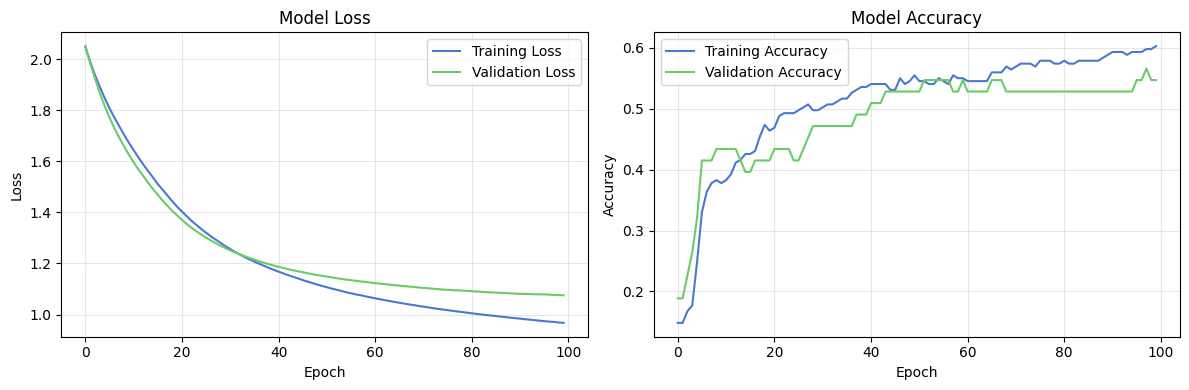

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Evaluate Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6463 - loss: 0.9399
TEST ACCURACY: 63.64%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


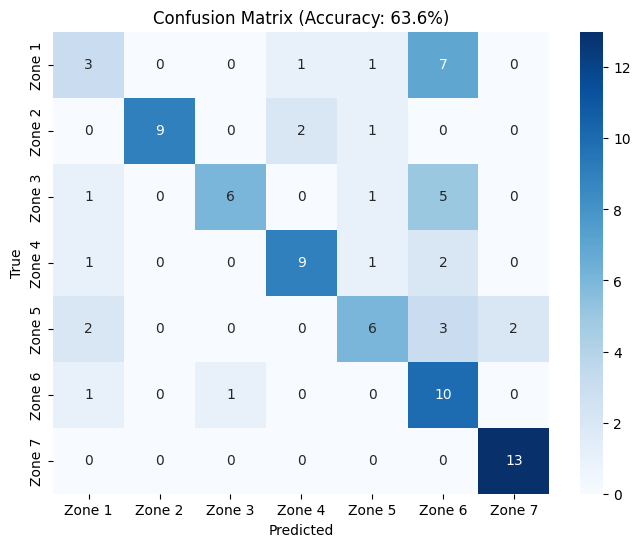


Per-location accuracy:
  Zone 1: 25.0%
  Zone 2: 75.0%
  Zone 3: 46.2%
  Zone 4: 69.2%
  Zone 5: 46.2%
  Zone 6: 83.3%
  Zone 7: 100.0%


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)

print("=" * 60)
print(f"TEST ACCURACY: {test_accuracy * 100:.2f}%")
print("=" * 60)

# Make predictions
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {test_accuracy*100:.1f}%)')
plt.show()

# Per-class accuracy
print("\nPer-location accuracy:")
for i, location in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred_classes[mask] == i).mean()
        print(f"  {location}: {acc*100:.1f}%")

## Step 10: Export Weights for ESP32

In [ ]:
# ========== STEP 10: EXPORT WEIGHTS FOR ESP32 (VERSION SANS BUG) ==========
import json
import numpy as np

# 1. Extraction des poids et des biais
try:
    # On tente de récupérer par noms de couches
    hidden_layer = model.get_layer('hidden')
    output_layer = model.get_layer('output')
except:
    # Sinon par index (0=hidden, 1=output)
    hidden_layer = model.layers[0]
    output_layer = model.layers[1]

W1, b1 = hidden_layer.get_weights()
W2, b2 = output_layer.get_weights()

# 2. Préparation du dictionnaire JSON
weights_dict = {
    "metadata": {
        "input_size": int(W1.shape[0]),
        "hidden_size": int(W1.shape[1]),
        "output_size": int(W2.shape[1]),
        "accuracy": float(test_accuracy) if 'test_accuracy' in locals() else 0.0
    },
    "W1": W1.tolist(),
    "b1": b1.tolist(),
    "W2": W2.tolist(),
    "b2": b2.tolist(),
    "mean": mean.tolist(),
    "std": std.tolist(),
    "ap_order": data.drop(columns=['target']).columns.tolist(),
    "locations": label_encoder.classes_.tolist()
}

# 3. Sauvegarde physique du fichier
file_name = 'nn_weights.json'
with open(file_name, 'w') as f:
    json.dump(weights_dict, f, indent=2)

print("--- EXPORTATION REUSSIE ---")
print(f"Fichier genere : {file_name}")
print(f"Zones enregistrees : {len(weights_dict['locations'])}")
print(f"Nombre de bornes WiFi : {len(weights_dict['ap_order'])}")

--- EXPORTATION REUSSIE ---
Fichier genere : nn_weights.json
Zones enregistrees : 7
Nombre de bornes WiFi : 10


## Step 11: Verify Export

In [ ]:
# Load and verify the exported file
with open('nn_weights.json', 'r') as f:
    loaded = json.load(f)

print("=" * 60)
print("VERIFICATION DU FICHIER EXPORTÉ")
print("=" * 60)

# Accès aux métadonnées (Structure ESP32)
meta = loaded['metadata']
print(f"Architecture : {meta['input_size']} IN -> {meta['hidden_size']} HIDDEN -> {meta['output_size']} OUT")

print(f"\nOrdre des bornes WiFi (AP Order) :")
for i, mac in enumerate(loaded['ap_order']):
    print(f"  AP_{i} = {mac}")

print(f"\nZones (Locations) : {loaded['locations']}")
print(f"Précision (Accuracy) : {meta['accuracy']*100:.2f}%")

# Vérification des poids
print("\nVerification des matrices de poids :")
print(f"  W1: {len(loaded['W1'])}x{len(loaded['W1'][0])}")
print(f"  W2: {len(loaded['W2'])}x{len(loaded['W2'][0])}")

print("=" * 60)
print("✅ FICHIER VALIDE ET PRÊT POUR L'ESP32")
print("=" * 60)

VERIFICATION DU FICHIER EXPORTÉ
Architecture : 10 IN -> 16 HIDDEN -> 7 OUT

Ordre des bornes WiFi (AP Order) :
  AP_0 = AP_0
  AP_1 = AP_1
  AP_2 = AP_2
  AP_3 = AP_3
  AP_4 = AP_4
  AP_5 = AP_5
  AP_6 = AP_6
  AP_7 = AP_7
  AP_8 = AP_8
  AP_9 = AP_9

Zones (Locations) : ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7']
Précision (Accuracy) : 63.64%

Verification des matrices de poids :
  W1: 10x16
  W2: 16x7
✅ FICHIER VALIDE ET PRÊT POUR L'ESP32


## Step 12: Download Files

In [ ]:
from google.colab import files

# Download nn_weights.json
files.download('nn_weights.json')

print("✓ Downloaded nn_weights.json")
print("\nNext steps:")
print("1. Copy nn_weights.json to SD card root")
print("2. Copy content_config.json to SD card root")
print("3. Copy images to /images/ folder on SD card")
print("4. Upload museum_guide_tab5_simple.ino to Tab5")
print("5. Test the system!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded nn_weights.json

Next steps:
1. Copy nn_weights.json to SD card root
2. Copy content_config.json to SD card root
3. Copy images to /images/ folder on SD card
4. Upload museum_guide_tab5_simple.ino to Tab5
5. Test the system!


## ✅ Avantages de Cette Méthode

**MQTT Direct vs CSV Upload:**

1. **Pas de téléchargement/upload**
   - Données viennent directement du broker
   - Gain de temps énorme

2. **Temps réel**
   - Les Tab5 uploadent → Google Colab reçoit
   - Pas d'étape intermédiaire

3. **Multi-groupes**
   - Parfait pour Cité des Sciences (4 groupes)
   - Chacun upload, Colab agrège tout

4. **Traçabilité**
   - Chaque message contient tab5_mac
   - On sait d'où viennent les données

5. **Automatisation**
   - Workflow simplifié
   - Moins d'erreurs humaines

**Workflow:**
```
Tab5 #1 → MQTT → Broker ← Google Colab
Tab5 #2 → MQTT → Broker ← (écoute 30s)
Tab5 #3 → MQTT → Broker ← (agrège tout)
Tab5 #4 → MQTT → Broker ← (→ training)
```